In [1]:
import pyvista as pv
import numpy as np
import math  

# From CAD to VOXEL

In [2]:
Path = 'Object\sphere.stl'
mesh = pv.read(Path)

x_min, x_max, y_min, y_max, z_min, z_max = mesh.bounds

scale_print= max(x_max - x_min,y_max - y_min,z_max - z_min)
# print(mesh.length)  diagonal
scale_voxel=0.1

voxels = pv.voxelize(mesh, density=scale_voxel, check_surface=False)

surface = voxels.extract_surface()
surface_points = surface.points
surface_points -= np.array([x_min,y_min,z_min]) 
surface_points = np.divide(surface_points, scale_voxel).astype(int)
surface_points

pyvista_ndarray([[ 7, 11,  0],
                 [ 7, 12,  0],
                 [ 7, 12,  1],
                 ...,
                 [19, 12, 25],
                 [19, 13, 25],
                 [19, 14, 25]])

# VOXEL model

In [88]:
class Voxels():
    
    def __init__(self, scale_print, scale_voxel):
        
        self.scale_print = scale_print
        self.scale_voxel = scale_voxel

        self.nb_voxels = math.ceil(scale_print/scale_voxel)
        
        self.voxels = np.zeros((self.nb_voxels,self.nb_voxels,self.nb_voxels))

    def Voxelise_object(self,object):
        Path = object
        mesh = pv.read(Path)

        x_min, x_max, y_min, y_max, z_min, z_max = mesh.bounds

        voxels = pv.voxelize(mesh, density=self.scale_voxel, check_surface=False)

        surface = voxels.extract_surface()
        surface_points = surface.points
        surface_points -= np.array([x_min,y_min,z_min]) 
        surface_points = np.divide(surface_points, scale_voxel).astype(int)
        return surface_points

    def add_density(self, coord):

        self.voxels[coord[:,0],coord[:,1],coord[:,2]]=1

    def substracted_density(self,coord):
        
        self.voxels[coord[:,0],coord[:,1],coord[:,2]]=0

    def density(self, coord):
        density_bool = self.voxels[coord[:,0],coord[:,1],coord[:,2]]==1
        return not np.any(~density_bool)
    

    def move_object_translation(self, object, position_ini, position_fin, scale=True):  
        # scale : In the good referential
        object = object.astype(np.float64)
        object += (position_fin - position_ini)*(self.scale_voxel*(1-scale)+scale)

        if  not scale :          # correction move to be affected at the good voxel
            return np.floor(object).astype(int)
        return object.astype(int)
    

    def move_object_rotation(self, object, phi, theta):
        
        object= rot_theta = np.array([np.cos(theta), -np.sin(theta)],
                                      [-np.sin(theta), -np.cos(theta)]) @ object.T
        rot = np.eye(3)
        # # Y - > z vers x
        rot_phi = np.array([[np.cos(phi), 0, np.sin(phi)],
                            [0, 1, 0],
                            [-np.sin(phi), 0, np.cos(phi)]])
        rot = rot_phi @ rot

        # Z -> x vers y
        rot_theta = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [-np.sin(theta), -np.cos(theta), 0],
                            [0, 0, 1]])
        rot = rot_theta @ rot

        object_rot = rot @ object.T
        return np.floor(object_rot).astype(int).T



In [27]:
voxel=Voxels(scale_print,scale_voxel)
voxel.voxels.shape

(26, 26, 26)

In [20]:
voxel.add_density(surface_points)
voxel.density(surface_points)

True

c:\Users\sdesg\Documents\Voxel_py310\myenv\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


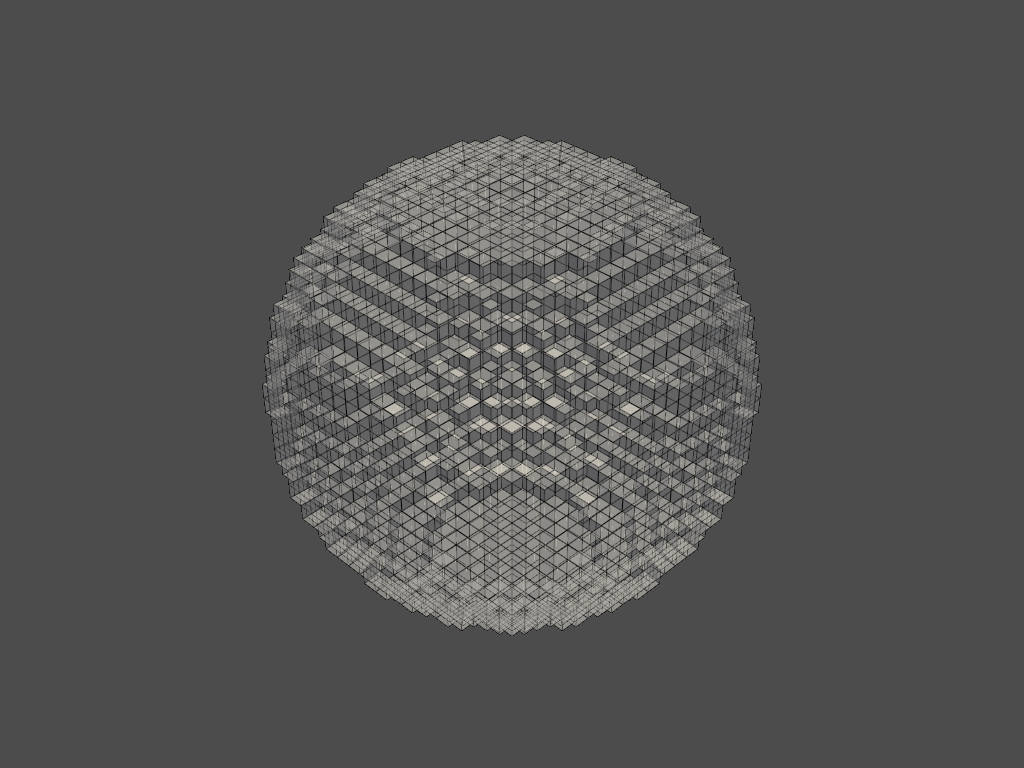

In [22]:
p = pv.Plotter()
p.add_mesh(surface, color=True, show_edges=True, opacity=0.5)
p.show()


# Change of position

-Translation test

In [23]:
object = surface_points
position_ini=np.array([ 7, 11,  0])
position_fin=np.array([0, 0, 0])
object

pyvista_ndarray([[ 7, 11,  0],
                 [ 7, 12,  0],
                 [ 7, 12,  1],
                 ...,
                 [19, 12, 25],
                 [19, 13, 25],
                 [19, 14, 25]])

In [24]:
voxel.move_object_translation(object,position_ini,position_fin)

pyvista_ndarray([[ 0,  0,  0],
                 [ 0,  1,  0],
                 [ 0,  1,  1],
                 ...,
                 [12,  1, 25],
                 [12,  2, 25],
                 [12,  3, 25]])

-Rotation test

In [31]:
def move_object_rotation_2(object, phi_ini,delta_phi, theta_ini, delta_theta):

    rot = np.array([[np.cos(delta_theta)*np.cos(delta_phi), -np.cos(delta_theta)*np.sin(delta_phi), np.sin(delta_theta)*np.cos(delta_phi+phi_ini)],
                    [-np.sin(phi_ini)*np.cos(delta_theta), np.cos(phi_ini)*np.cos(delta_theta), -np.sin(delta_theta)*np.sin(phi_ini-delta_phi)],
                    [0, 0, np.cos(delta_theta)]])
    
    vect=np.array([0,0,np.sin(theta_ini)*np.sin(delta_theta)])
    object_rot = rot @ object.T - vect.T
    return np.floor(object_rot).astype(int).T

theta [0 , pi]
phi [0, 2pi]

In [36]:
phi_ini,delta_phi, theta_ini, delta_theta = 0 , 0 , np.pi/2 , np.pi/2
point_rotate= move_object_rotation_2(np.array([1, 0, 0]),phi_ini,delta_phi, theta_ini, delta_theta) 
point_rotate

array([ 0,  0, -1])

In [81]:
def move_object_rotation(object, phi, theta):
        
        object= np.array([[np.cos(theta), -np.sin(theta), 0],
                          [-np.sin(theta), -np.cos(theta), 0],
                          [0, 0, 1]])   @ object.T
        rot = np.eye(3)
        # # Y - > z vers x
        rot_phi = np.array([[np.cos(phi), 0, np.sin(phi)],
                            [0, 1, 0],
                            [-np.sin(phi), 0, np.cos(phi)]])
        rot = rot_phi @ rot

        # Z -> x vers y
        rot_theta = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [-np.sin(theta), -np.cos(theta), 0],
                            [0, 0, 1]])
        rot = rot_theta @ rot

        object_rot = rot @ object.T
        return np.floor(object_rot).astype(int).T

In [85]:
theta = np.radians(0)
phi = np.radians(80)
point = np.array([[0, 0, 1],
                  [0, 1, 0],
                  [1, 0, 0],])

In [83]:
point_rotate= move_object_rotation(point,phi, theta)  
# [[0, 0, 1],
#  [0, 1, 0],
#  [1, 0, 0],])
point_rotate

array([[ 1,  0,  0],
       [ 0,  0, -1],
       [ 0, -1,  0]])

In [60]:
point=np.array([[1,0,0,1]])

-phi -> Z

-theta -> x vers Y

-Vector Creation 

In [91]:
def Vector_Creation(theta, angle_max):
    qotient = int(angle_max // theta) + 1
    circles = np.array([[k,k*theta,np.arccos((np.cos(theta)-np.cos(k*theta)**2)/np.sin(k*theta)**2)] for k in range(1,qotient)])
    return circles

In [92]:
theta=np.pi / 6
angle_max=np.pi / 2
circle=Vector_Creation(theta, angle_max)

In [95]:
for c in circle:
    print(c[-1],c)

1.0881762133641693 [1.         0.52359878 1.08817621]
0.6069925038746671 [2.         1.04719755 0.6069925 ]
0.5235987755982987 [3.         1.57079633 0.52359878]


# Dijkstra's shortest path algorithm

In [97]:
import networkx as nx

In [98]:
G = nx.DiGraph()  # noeud orienté
G.add_weighted_edges_from([("A", "C",3),
                           ("A", "E",2),
                           ("A", "D",1),
                           ("D", "C",1)])

vectors = {
    "A": [1, 2, 3],
    "D": [4, 5, 6],
    "C": [7, 8, 9]
}
for sommet, vecteur in vectors.items():
    G.nodes[sommet]["vecteur"] = vecteur
shortest_path = nx.dijkstra_path(G, "A", "C")
shortest_path

['A', 'D', 'C']

# Free Path

In [89]:
def  FreePath(vector_head, tool_path, theta, theta_max, head_print_CAD, printed_object_CAD, scale_voxel, scale_print):

    vox = Voxels(scale_print,scale_voxel)

    surface_printed = vox.Voxelise_object(printed_object_CAD)
    vox.add_density(surface_printed)

    print_head = vox.Voxelise_object(head_print_CAD)


#   build_graph
    num_layers = len(tool_path)
    source = 's'
    target = 't'
    
    G = nx.DiGraph()
    G.add_node(source)
    G.add_node(target)
                
    layer_vertex = {i: [] for i in range(num_layers)}
    Circle=Vector_Creation(theta, angle_max)
    
    for i in range(num_layers):
        if i > 0:
            prev_layer = i - 1    # Récupérez les sommets de l'étage précédent
            prev_layer_vertices = layer_vertex[prev_layer]

        for j, vec1 in enumerate(Circle):
            position = move_object_rotation(print_head,tool_path[i], angle =(Circle[-2], Circle[-1])) # modifie la position de la tete dans les coordonnées associé au voxels
            if not vox.density(position): # s'il n'y a pas de desnité (pas d'obstacle)
                current_vertex = (i, j)  #  name of the vertex
                G.add_node(current_vertex, vector=vec1, angle=theta) # creer le sommet white atribute 
                layer_vertex[i].append(current_vertex)  # Ajoute les sommets aux listes d'étages
                if i > 0:
                    for prev_vertex in prev_layer_vertices: # creer des liaison entre les etages si la condition angulaire est respécté
                        angle = abs(G.nodes[prev_vertex]['angle']-G.nodes[current_vertex]['angle'])
                        if angle <= theta:
                            G.add_edge(prev_vertex, current_vertex, weight=angle)
                if i == 0:
                    G.add_edge(source, current_vertex, weight=0)
                if i == num_layers-1:
                    G.add_edge(current_vertex,target ,weight=0)
        vox.add_density(tool_path[i])

    shortest_path = nx.dijkstra_path(G, source, target)


    